# MD-SAPT: Python Based Toolkit for Running Symmetry Adapted Perturbation Theory Calculations of Molecular Dynamics Trajectories
### Alia Lescoulie, Astrid Yu, and Ashley Ringer McDonald

This Jupyter notebook demonstrates the MD-SAPT interactive user experience, showing the whole process for an example polypeptide from input to analysis.

In [1]:
# Ignore warnings.
import warnings
warnings.filterwarnings('ignore')

import mdsapt

2022-10-15 20:08:14,467 mdsapt       INFO     MD-SAPT v2.0.0 starting
2022-10-15 20:08:14,468 mdsapt       INFO     Copyright (c) 2021-2022 Alia Lescoulie, Astrid Yu, and Ashley Ringer McDonald
2022-10-15 20:08:14,468 mdsapt       INFO     Released under GPLv3 License


## Step 1: Input file

MD-SAPT uses YAML, a configuration file format, to pass settings in. Below is a copy of the input file uses in this demo. The input file contains all the information needed to run the SAPT calculations on the trajectory, such as:
- paths to the MD data
- the residues of interest
- the frames to run
- the computing recourses requested

Below is the input used in this notebook. Template inputs are generated using the following command:

```bash
mdsapt generate [your-file.yml]
```

Afterwards the input file is filled out with the needed information.

```YAML
psi4:
  method: "sapt0"
  basis: "jun-cc-pvdz"
  settings:
    reference: "rhf"
  save_output: true
simulation:
  ph: 7.0
  charge_guesser: "standard"
  # charge_guesser: 'rdkit'  # to use rdkit. Make sure it is installed first.
system_limits:
  ncpus: 32
  memory: "80GB"
analysis:
  ### This section is for running TrajectorySAPT. To run other types of analyses, see below.
  type: "trajectory"

  topology: testtop.psf
  trajectories:
    - testtraj.dcd
  pairs:
    # Place pair of  selections defined above in a list of lists
    - [109, 196]
    - [197, 199]
    - [208, 200]
    - [156, 44]
    - [84, 13]
  frames:
    start: 78
    stop: 97
    step: 1

  output: "output.csv"
```

To run it using your filled-in settings, you can use the following command:

```
mdsapt run [your-file.yml]
```

and it will output a CSV. 

Alternatively, you can interact with MDSAPT programmatically, like so:

In [2]:
config = mdsapt.load_from_yaml_file('input.yaml')

This function creates a **Config** object. Creating a config object also checks the input file for errors and inconsistencies, and gives the location of issues in the input file. This saves valuable cluster time.

For example, if the stop frame selected in the input file exceeds the trajectory length, MD-SAPT will raise an error:

```YAML
analysis:
  frames:
    start: 78
    stop: 120
```

In [3]:
config = mdsapt.load_from_yaml_file('error_input.yaml')

2022-10-15 20:08:14,604 mdsapt.config ERROR    Error while loading config from 'error_input.yaml'
Traceback (most recent call last):
  File "/home/astrid/miniconda3/envs/mdsaptdemo/lib/python3.9/site-packages/mdsapt/config.py", line 373, in load_from_yaml_file
    return Config(**yaml.safe_load(file))
  File "pydantic/main.py", line 342, in pydantic.main.BaseModel.__init__
pydantic.error_wrappers.ValidationError: <unprintable ValidationError object>


RuntimeError: Unknown error object: Stop 120 exceeds trajectory length 98.

## Step 2: Run SAPT Over Trajectory Frames

After the residues are prepared, SAPT is run on the specificed residues using the **TrajectorySAPT** object. It performs several steps:
1. Getting the trajectory coordinates from the MD files
2. Converting the residue coordinates into a Psi4 input file
3. Running the SAPT calculation with the Psi4 method and basis set specified in the input
4. Saving the results into a **DataFrame** for easy analysis

Due to the limited memory in a Binder instance, the SAPT calculations for this trajectory were pre-run on a more powerful server, and the **TrajectorySAPT** object was "pickled" so it can be demonstrated here.

In [4]:
import pickle

sapt_run = mdsapt.TrajectorySAPT(config)

try:
    # SAPT takes a very long time! On a 32-core machine with 74GiB allocated,
    # it took about 2 hours. So, we pre-ran a TrajectorySAPT for this demo 
    # notebook.
    with open('results.pkl', 'rb') as file:
        results = pickle.load(file)

except FileNotFoundError:
    # If you really want to run the entire SAPT yourself, delete sapt_run.pkl
    # and run this cell again.
    sapt_run.run(start=config.analysis.start, stop=config.analysis.stop, step=config.analysis.step)
    results = sapt_run.results
    with open('results.pkl', 'wb') as file:
        pickle.dump(results, file)

## Step 3: Results Analysis

With the results **DataFrame**, the interaction energies can be viewed and used to generate figures.

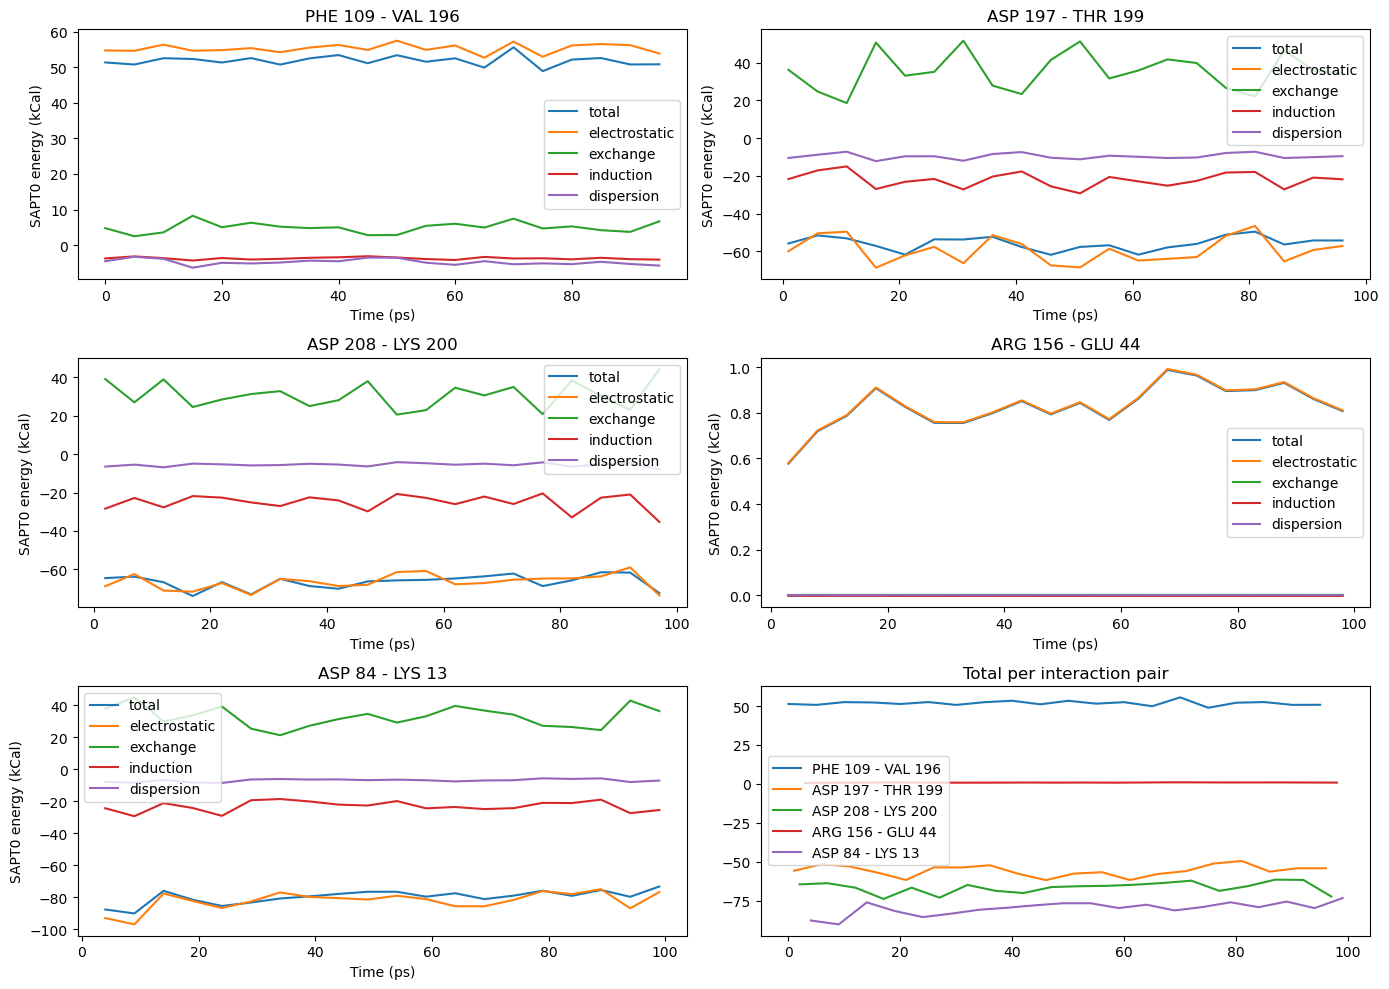

In [5]:
import matplotlib.pyplot as plt

# Generate 3x2 subplots
fig, axs = plt.subplots(3, 2, figsize=(14, 10))
axs = axs.flatten()

# Draw individual pairs in first 5, and total in last 1.
indiv_axs = axs[:5]
total_ax = axs[-1]

residue_pairs = results['residues'].unique()

total_ax.set_title('Total per interaction pair')

for r_pair, ax in zip(residue_pairs, indiv_axs):
    # Filter the results by those associated with this pair.
    df = results.loc[results['residues'] == r_pair]
    
    # From the residue pair numbers, grab their amino acid names.
    a, b = map(int, r_pair.split('-'))
    ra, rb = (sapt_run._unv._topology.resnames.values[int(k) - 1] for k in (a, b))
    i_name = f'{ra} {a} - {rb} {b}'

    # Plot individual interactions on their own subplots.
    ax.set_title(i_name)
    ax.set_xlabel('Time (ps)')
    ax.set_ylabel('SAPT0 energy (kCal)')
    for key in ['total', 'electrostatic', 'exchange', 'induction', 'dispersion']:
        ax.plot(df[key], label=key)
    
    # Plot total interactions on the aggregated axis.
    total_ax.plot(df['total'], label=i_name)

# Draw legends per-axis.
for ax in axs:
    ax.legend()

fig.tight_layout()
plt.show()